# Data Processing
Transform data from SEPRSCO Format to Piano Roll-like (matrix).

In [2]:
import os
from pathlib import Path
import pickle
import sys
import subprocess

import cv2
import matplotlib.pyplot as plt
import numpy as np
import IPython
from tqdm import tqdm

ROOT_DIR = os.path.abspath('..')  # ROOT_DIR = Path(__file__).parents[1].resolve()
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
sys.path.append(ROOT_DIR)

# TODO: Use importlib.
from components.common.configuration import DataProcessorConfiguration
from components.common.logger_manager import LoggerManager
from components.data_processor.data_processor import DataProcessor
from components.data_processor.data_processor import *  # TODO: Import properly.

RANDOM_SEED = 13131313
np.random.seed(RANDOM_SEED)

In [3]:
logger = LoggerManager(None)             
config = DataProcessorConfiguration({
    'replace_if_exists': False,
    'representation': 'roll',
    'sample_len': 256,
    'cutting_step': 256,
    'rows': 8
})
DATA_DIR = ROOT_DIR / Path('data')

In [5]:
data_processor = DataProcessor(config, logger)
data_processor.download_data(DATA_DIR / Path('nesmdb24_seprsco'))

original_data_path = DATA_DIR / Path('nesmdb24_seprsco_train')
original_song = read_seprsco_song(original_data_path / Path('297_SkyKid_00_01StartMusicBGMIntroBGM.seprsco.pkl'))
print(f'\n{original_song}')

24-03-26 09:42:31 [DataProcessor] INFO     Initialized Data Processor.
24-03-26 09:42:31 [DataProcessor] INFO     Downloaded sepsco data. Example: rate=24.0, nsamps=2465552, seprsco=[[76 76 76 ... 76 76 76]
 [ 0  0  0 ... 76 76 76]
 [64 64 64 ... 59 59 59]
 [15 15 15 ... 14 14 14]].

[[41 41 41 ... 77 77 77]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  0  0  0]]


In [6]:
scaled_data_path = DATA_DIR / Path('nesmdb24_seprsco_train_scaled')
data_processor.scale(original_data_path, scaled_data_path)
np.load(scaled_data_path / Path('297_SkyKid_00_01StartMusicBGMIntroBGM.seprsco.npy'))

array([[0.12987013, 0.12987013, 0.12987013, ..., 0.5974026 , 0.5974026 ,
        0.5974026 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0625    , 0.0625    , 0.0625    , ..., 0.        , 0.        ,
        0.        ]])

Number of samples: 13003.


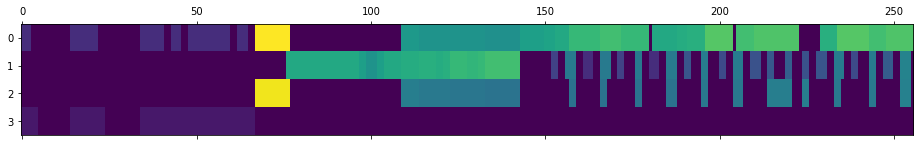

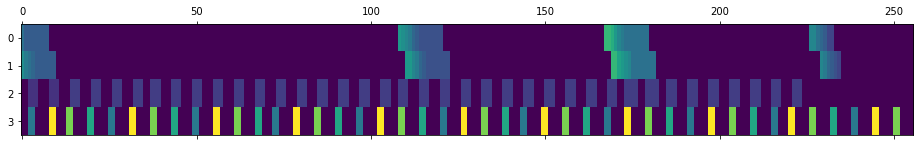

In [7]:
cuts_dir = DATA_DIR / Path('nesmdb24_seprsco_train_cut')
data_processor.cut(scaled_data_path, cuts_dir)
print(f'Number of samples: {len(list(cuts_dir.iterdir()))}.')

song = np.load(cuts_dir / Path('297_SkyKid_00_01StartMusicBGMIntroBGM.seprsco__0.npy'))
plt.matshow(song, interpolation='none', aspect='auto')

song = np.load(cuts_dir / Path('298_SolarJetman_HuntfortheGoldenWarpship_22_23ShishkebabGameplay.seprsco__10.npy'))
plt.matshow(song, interpolation='none', aspect='auto')

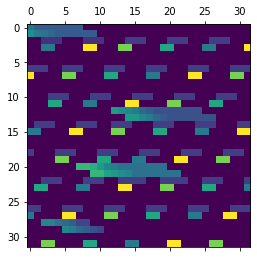

In [8]:
train_data_dir = DATA_DIR / Path('nesmdb24_seprsco_train_ready')
data_processor.represent(cuts_dir, train_data_dir)

song = np.load(train_data_dir / Path('298_SolarJetman_HuntfortheGoldenWarpship_22_23ShishkebabGameplay.seprsco__10.npy'))
plt.matshow(song, interpolation='none', aspect='auto')

## Test

In [ ]:
back_cuts_dir = DATA_DIR / Path('nesmdb24_seprsco_sampled') / Path('cuts_back')
back_dir = DATA_DIR / Path('nesmdb24_seprsco_sampled') / Path('train_back')
data_processor.unrepresent(train_data_dir, back_cuts_dir)
data_processor.unscale(back_cuts_dir, back_dir)

back_song = read_seprsco_song(back_dir / Path('297_SkyKid_00_01StartMusicBGMIntroBGM.seprsco__0.pkl'))
print(f'\n{back_song}')

In [ ]:
np.testing.assert_array_equal(original_song[:, :256], back_song)

---
# SEPRSCO Dataset Research

In [ ]:
HIST_RANGE = 108

cnt, mins, mins_ex_zero, mean_sums, maxs = 0, np.array([255, 255, 255, 255], dtype='uint8'), \
    np.array([255, 255, 255, 255], dtype='uint8'), np.array([0.0, 0.0, 0.0, 0.0], dtype='float64'), \
    np.array([0, 0, 0, 0], dtype='uint8')
bins, hists = np.arange(HIST_RANGE + 1), [np.zeros([HIST_RANGE,]) for _ in range(4)]

for file in (DATA_DIR / Path('nesmdb24_seprsco') / Path('train')).iterdir():
    with open(file, 'rb') as f:
        rate, nsamps, seprsco = pickle.load(f)

        mins = np.minimum(mins, seprsco.min(axis=0))
        mean_sums += seprsco.mean(axis=0)
        maxs = np.maximum(maxs, seprsco.max(axis=0))
        cnt += 1

        for hi in range(4):
            hists[hi] += np.histogram(seprsco[:, hi], bins=bins)[0]

        seprsco[seprsco == 0] = 255
        mins_ex_zero = np.minimum(mins_ex_zero, seprsco.min(axis=0))

print(f'Number of samples: {cnt}.')
print(f'Min values: {mins}.')
print(f'Non-zero min values: {mins_ex_zero}.')
print(f'Mean values: {mean_sums / cnt}.')
print(f'Max values: {maxs}.')

In [ ]:
plt.figure()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

x = np.arange(HIST_RANGE)
axs[0][0].bar(x, hists[0])
axs[0][1].bar(x, hists[1])
axs[1][0].bar(x, hists[2])
axs[1][1].bar(x, hists[3])

for i in range(2):
    for j in range(2):
        axs[i][j].grid()

**Instruments [[NESMDB README](https://github.com/chrisdonahue/nesmdb#nes-synthesizer-primer)]:**

- Pulse 1 (P1): {0, 32, ..., 108}

- Pulse 2 (P2): {0, 32, ..., 108}

- Triangle (TR): {0, 21, ..., 108}

- Noise (NO): {0, 1, ... 16}

**Why non-zero min values are 33, not 32?**

# To wav, to spectrogram
TODO: Try?